In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge,LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from statsmodels.api import OLS
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from copy import deepcopy
from scipy.stats import probplot

In [2]:
cl_res=pd.read_csv('augmentation_ablations_cl_res.csv')
cl_res=cl_res[cl_res['model name']!='native']
mc_res=pd.read_csv('augmentation_ablations_mc_res.csv')

mc_res=mc_res[mc_res['model name']!='native']
mc_res['score']=mc_res['pr correct'] #naming consistency for analysis 

diff_res=pd.read_csv('augmentation_ablations_mc_diff.csv')
diff_res=diff_res[diff_res['model name']!='native']
diff_res['score']=diff_res['comp minus mix']



In [3]:
freeform_res=pd.read_csv('augmentation_ablations_freeform_res.csv')
freeform_res['model name']=freeform_res['model']
freeform_res=freeform_res[(freeform_res['model']!='native')&(freeform_res['model']!='gp oracle')&(freeform_res['model']!='ar')]
freeform_res['score']=freeform_res['corr']


In [4]:
regs=[]
ys=[]
for res,name in zip([cl_res,mc_res,freeform_res],['cl','mc']):
    p1=np.array([1*('yjitter' in x) for x in res['model name']])
    p2=np.array([1*('posjitter' in x) for x in res['model name']])
    p3=np.array([1*('rescale' in x) for x in res['model name']])
    p4=res['train size']
    y=res['score']
    #y=np.log(y/(1-y)) #convert to log odds (linear scale)
    #y=np.argsort(np.argsort(y))

    X=np.vstack((p1,p2,p3,p4,y)).T
    X=pd.DataFrame(X,columns=['T1','T2','T3','ntr','score'])
    print(name)
    reg=ols('score~T1+T2+T3+C(ntr)',X)
    rf=reg.fit()
    regs.append(deepcopy(rf))
    ys.append(deepcopy(y.values))
    print(len(y),len(p4))
    print(rf.summary())

cl
1050 1050
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1531.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        09:18:08   Log-Likelihood:                 1772.4
No. Observations:                1050   AIC:                            -3529.
Df Residuals:                    1042   BIC:                            -3489.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3208   

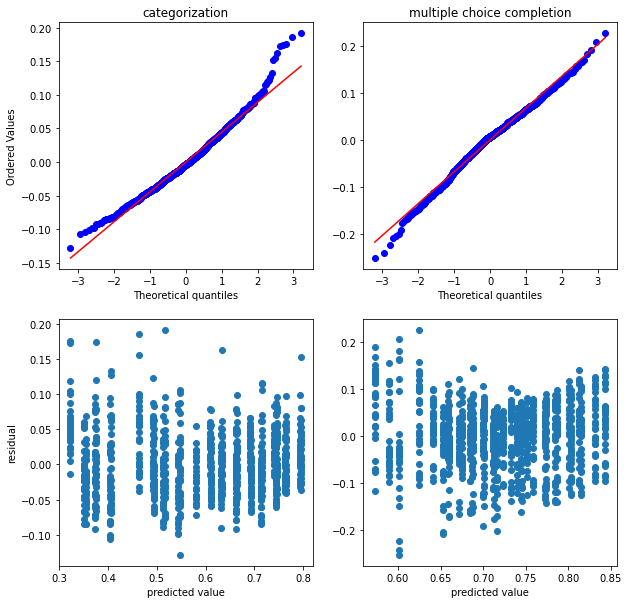

In [5]:
#residual diagnostics
plt.figure(figsize=(10,10))
for i0 in range(2):
    ax=plt.subplot(2,2,i0+1)
    resids=regs[i0].fittedvalues-ys[i0]
    probplot(resids,plot=ax,fit=True)
    plt.title(['categorization','multiple choice completion'][i0])
    if i0>0:
        plt.ylabel('')
    plt.subplot(2,2,i0+1+2)
    plt.scatter(regs[i0].fittedvalues,resids)
    plt.xlabel('predicted value')
    if i0==0:
        plt.ylabel('residual')
plt.savefig('aug_ablation_residuals.pdf')

In [6]:
#computing bootstrapped confide
res_type='freeform'
q='_res' if res_type!='mc_diff' else ''
aa=pd.read_csv(f'saved_models_{res_type}{q}.csv')
#for bootstrapping, need to separately treat the "native" model bc there are fewer observations
try:
    aa['model name']=aa['model']
except:
    pass
aa,aa_native=aa[aa['model name']!='native'],aa[aa['model name']=='native']
aa=aa[aa['train size']>0]

In [7]:
value_name=dict({'cl':'score','mc':'pr correct','mc_diff':'comp minus mix','freeform':'corr'})[res_type]
#reshape dataframe so that all observations for given model/trian size are in different columns
bb=aa.pivot_table(values=value_name,index=['model name','train size'],columns=['run id','task id']).reset_index()
bb_native=np.array([aa_native[aa_native['train size']==x][value_name].values for x in sorted(aa_native['train size'].unique())])

In [8]:
#bootstrap sample mean estimates
sample_means=[]
sample_means_native=[]
for _ in range(10): #10000
    ids=np.random.choice(30,30,replace=True)
    sample_means.append(bb[bb.columns[2:][ids]].mean(1).values)
    ids=np.random.choice(10,10,replace=True)
    sample_means_native.append(bb_native[:,ids].mean(1))

sample_means=np.array(sample_means).T
sample_means_native=np.array(sample_means_native).T
    

In [9]:
lci,uci=np.percentile(sample_means,2.5,axis=1),np.percentile(sample_means,97.5,axis=1),

In [10]:
bb_ci=bb[['model name','train size']]
bb_ci['mean']=bb[bb.columns[2:]].mean(1).values
bb_ci['lci'],bb_ci['uci']=lci,uci


bb_ci_native=pd.DataFrame(columns=bb_ci.columns)
bb_ci_native['mean']=bb_native.mean(1)
bb_ci_native['model name']='native'
bb_ci_native['train size']=sorted(bb['train size'].unique())
bb_ci_native['lci']=np.percentile(sample_means_native,2.5,axis=1)
bb_ci_native['uci']=np.percentile(sample_means_native,97.5,axis=1)

bb_ci=pd.concat((bb_ci,bb_ci_native))
bb_ci['ci width']=.5*(bb_ci['uci']-bb_ci['lci'])

<ipython-input-10-5dbf48989566>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_ci['mean']=bb[bb.columns[2:]].mean(1).values
<ipython-input-10-5dbf48989566>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_ci['lci'],bb_ci['uci']=lci,uci


In [11]:
xx=bb_ci.pivot_table(index='model name', columns='train size',values='ci width')*100

/home/simon/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [12]:
#reorder rows for direct comparisno with table in writeup
xx=xx.reindex(['contrastive','cnp','cpc','native','t-loss','tnc_catwindow','vae','contrastive-cnp-encoder','contrastive-fc-encoder'])

In [13]:
print(xx.to_latex())

\begin{tabular}{lrrrrr}
\toprule
task id \\
train size &       1   &       3   &       10  &       30  &       100 \\
model name              &           &           &           &           &           \\
\midrule
contrastive             &  1.353537 &  1.772430 &  1.037958 &  0.983861 &  0.979752 \\
cnp                     &  2.457306 &  2.094562 &  1.530885 &  1.247936 &  0.989231 \\
cpc                     &  1.588626 &  2.729347 &  1.797128 &  1.442742 &  1.244126 \\
native                  &  2.110540 &  3.444988 &  3.249204 &  2.398709 &  1.714228 \\
t-loss                  &  1.798841 &  2.041732 &  0.877112 &  1.004609 &  1.003064 \\
tnc\_catwindow           &  2.063345 &  1.929521 &  0.971577 &  1.051583 &  0.951397 \\
vae                     &  2.548386 &  2.948783 &  2.338728 &  2.602162 &  2.685770 \\
contrastive-cnp-encoder &  1.744545 &  1.796979 &  0.966032 &  1.000981 &  0.979630 \\
contrastive-fc-encoder  &  1.634464 &  2.168969 &  1.273548 &  1.371772 &  1.080000 \\
\b

In [14]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [15]:
#set up regression with hyperparameter value as main effect 
aa['value']=aa[value_name]
aa['run_id']=aa['run id']
aa['task_id']=aa['task id']
aa['model_name']=aa['model name']
aa['train_size']=aa['train size']


In [16]:
o=ols('value~C(task_id)+C(model_name)+C(train_size)',aa).fit()
anova_lm(o)

,df,sum_sq,mean_sq,F,PR(>F)
C(task_id),9.0,0.873982,0.097109,29.119538,3.063869e-46
C(model_name),8.0,8.614636,1.076830,322.902482,1.200574e-295
C(train_size),4.0,11.208662,2.802165,840.268692,0.000000e+00
Residual,1228.0,4.095189,0.003335,NaN,NaN


In [17]:
o.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     295.5
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        09:18:09   Log-Likelihood:                 1802.0
No. Observations:                1250   AIC:                            -3560.
Df Residuals:                    1228   BIC:                            -3447.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0465      0.010      4.617      0.000       0.027       0.066
C(task_id)[T.1]                             -0.0508      0.007     -6.953      0.000      -0.065      -0.036
C(task_id)[T.2]                             -0.0577      0.007     -7.902      0.000      -0.072      -0.043
C(task_id)[T.3]                             -0.0463      0.007     -6.332      0.000      -0.061      -0.032
C(task_id)[T.4]                             -0.0509      0.007     -6.969      0.000      -0.065      -0.037
C(task_id)[T.5]                             -0.0285      0.007     -3.907      0.000      -0.043      -0.014
C(task_id)[T.6]                             -0.0160      0.007     -2.190      0.029      -0.030      -0.002
C(task_id)[T.7]                             -0.0701      0.007     -9.593      0.000      -0.084      -0.056
C(task_id)[T.8]                             -0.0008      0.007     -0.107      0.915      -0.015       0.014
C(task_id)[T.9]                             -0.0807      0.007    -11.042      0.000      -0.095      -0.066
C(model_name)[T.cnp]                         0.1952      0.009     20.695      0.000       0.177       0.214
C(model_name)[T.contrastive]                 0.3778      0.009     40.062      0.000       0.359       0.396
C(model_name)[T.contrastive-cnp-encoder]     0.1970      0.009     20.893      0.000       0.179       0.216
C(model_name)[T.contrastive-fc-encoder]      0.3164      0.009     33.555      0.000       0.298       0.335
C(model_name)[T.cpc]                         0.2850      0.009     30.221      0.000       0.266       0.303
C(model_name)[T.t-loss]                      0.3168      0.009     33.591      0.000       0.298       0.335
C(model_name)[T.tnc_catwindow]               0.2711      0.009     28.744      0.000       0.253       0.290
C(model_name)[T.vae]                         0.1841      0.009     19.520      0.000       0.166       0.203
C(train_size)[T.3]                           0.1327      0.005     25.683      0.000       0.123       0.143
C(train_size)[T.10]                          0.2181      0.005     42.219      0.000       0.208       0.228
C(train_size)[T.30]                          0.2422      0.005     46.889      0.000       0.232       0.252
C(train_size)[T.100]                         0.2538      0.005     49.135      0.000       0.244       0.264
==============================================================================
Omnibus:                       40.639   Durbin-Watson:                   1.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.761
Skew:                          -0.121   Prob(JB):                     2.65e-21
Kurtosis:                       4.327   Co